In [1]:
# basic
import sys
import os
import os.path as op

# common
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


In [2]:
import dask
dask.config.set(scheduler='threads')

In [3]:
# for additional plotting functionality/data - not stricly necessary since rompy has plotting functions
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# from shapely import wkt
import shapely
from shapely.geometry import shape
from shapely.geometry import Point, LineString,Polygon, MultiPolygon
from shapely.geometry import MultiPoint
from shapely import geometry
import geopandas as gpd

In [4]:
def redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))
        

def resample_polygon(xy: np.ndarray, n_points: int = 100) -> np.ndarray:
    # Cumulative Euclidean distance between successive polygon points.
    # This will be the "x" for interpolation
    d = np.cumsum(np.r_[0, np.sqrt((np.diff(xy, axis=0) ** 2).sum(axis=1))])

    # get linearly spaced points along the cumulative Euclidean distance
    d_sampled = np.linspace(0, d.max(), n_points)

    # interpolate x and y coordinates
    xy_interp = np.c_[
        np.interp(d_sampled, d, xy[:, 0]),
        np.interp(d_sampled, d, xy[:, 1]),
    ]
    
    return xy_interp

In [5]:
fname='/datasets/work/oa-vankirap/work/GIS_layers/EOMAP/Shoreline/SLP_VUT_Vanuatu_EOMAP_2021.shp'
# fname='/datasets/work/oa-vankirap/work/GIS_layers/EOMAP/Shoreline/SLP_VUT_Vanuatu_EOMAP_2021_polygon.shp'
shoreline_gdf = gpd.read_file(fname)

In [6]:
# convert crs to  WGS 84 / UTM zone 59S projection
shoreline_gdf = shoreline_gdf.to_crs("EPSG:32759")
shoreline_gdf['perimiter'] = [k for k in shoreline_gdf.geometry.length]

In [7]:
shoreline_gdf

,Id,ORIG_FID,geometry,perimiter
0,0,0,"LINESTRING (370820.000 7759130.000, 370820.000...",180.000000
1,0,0,"LINESTRING (371000.000 7759160.000, 371000.000...",240.000000
2,0,0,"LINESTRING (370610.000 7759410.000, 370610.000...",180.000000
3,0,0,"LINESTRING (373620.000 7760020.000, 373620.000...",320.000000
4,0,0,"LINESTRING (377880.000 7760370.000, 377880.000...",200.000000
...,...,...,...,...
670,0,0,"LINESTRING (18338.656 8538330.862, 18338.896 8...",160.402933
671,0,0,"LINESTRING (21722.146 8544037.228, 21722.385 8...",240.591101
672,0,0,"LINESTRING (17566.767 8545462.472, 17567.483 8...",160.404836
673,0,0,"LINESTRING (17706.404 8547601.784, 17706.642 8...",200.505525


In [8]:
coast_dx = 2000 # Spacing of coastal ponts. If crs is UTM, this is in metres
# Remove islands smaller than the coastal spacing.  Otherwise the coastal points tend to be very noisy
temp_gdf = shoreline_gdf[shoreline_gdf['perimiter']>=coast_dx]

In [9]:
temp_gdf

,Id,ORIG_FID,geometry,perimiter
13,0,0,"LINESTRING (371880.000 7760690.000, 371880.000...",3040.000000
20,0,0,"LINESTRING (373980.000 7761900.000, 373980.000...",3860.000000
34,0,0,"LINESTRING (385420.000 7767100.000, 385420.000...",99840.000000
36,0,0,"LINESTRING (337730.000 7827330.000, 337730.000...",2160.000000
43,0,0,"LINESTRING (339510.000 7830390.000, 339510.000...",2280.000000
...,...,...,...,...
658,0,0,"LINESTRING (136247.284 8532061.569, 136247.524...",2921.821242
660,0,0,"LINESTRING (21450.330 8531095.207, 21450.571 8...",2566.318798
664,0,0,"LINESTRING (23570.626 8534665.737, 23570.866 8...",41960.369401
666,0,0,"LINESTRING (23387.750 8536857.319, 23387.990 8...",10325.187359


In [10]:
##
coastpoints_gdf = gpd.GeoDataFrame()
# for geom in shapefile.geometry:
#     geom_redux = geom_redux = redistribute_vertices(geom, 0.05)
#     # geom_redux=geometry.Point([p for p in geom_redux.coords.xy])
#     geom_redux=MultiPoint(geom_redux.coords)
#     # geom_redux=shapely.multipoints(geom_redux)
#     # this_df = pd.DataFrame({'geometry':[geom_redux]})
#     coastpoints_df.append(geom_redux)

coastpoints_gdf["id"]   = [k for k in temp_gdf.Id.values]
coastpoints_gdf["name"] = [k for k in temp_gdf.ORIG_FID.values]
coastpoints_gdf["geometry"]  = [MultiPoint(redistribute_vertices(geom, coast_dx).coords) for geom in temp_gdf.geometry] 

In [11]:
coastpoints_gdf=coastpoints_gdf.set_crs(crs=shoreline_gdf.crs)

In [12]:
shoreline_gdf.crs

<Derived Projected CRS: EPSG:32759>
Name: WGS 84 / UTM zone 59S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 168°E and 174°E, southern hemisphere between 80°S and equator, onshore and offshore. New Zealand.
- bounds: (168.0, -80.0, 174.0, 0.0)
Coordinate Operation:
- name: UTM zone 59S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# coastpoints_df = gpd.GeoDataFrame(coastpoints_df)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/plotting.py:306: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  collection = ax.scatter(x, y, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


<AxesSubplot:>

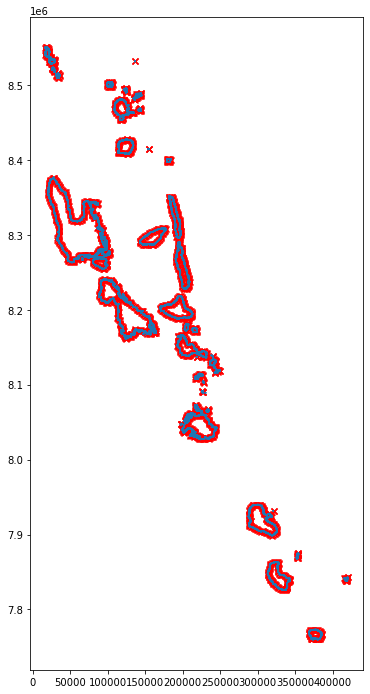

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,12)) #, subplot_kw={'projection': ccrs.PlateCarree()})
shoreline_gdf.plot(ax=ax)
coastpoints_gdf.plot(ax=ax,marker= 'x', edgecolor='r', facecolor='r')

In [15]:
# crs = ccrs.AzimuthalEquidistant()
# # crs = ccrs.PlateCarree()
# crs_proj4 = crs.proj4_init
# shoreline_gdf4plot = shoreline_gdf.to_crs(crs_proj4)
# coastpoints_gdf4plot = coastpoints_gdf.to_crs(crs_proj4)

# cp4plot = [crs.project_geometry(ii, src_crs=crs)
#                   for ii in coastpoints_gdf['geometry'].values]

# fig, ax = plt.subplots(1, 1, figsize=(20,20), subplot_kw={'projection': ccrs.PlateCarree()})

# ax.add_geometries(shoreline_gdf4plot['geometry'], crs=crs)
# # coastpoints_gdf.plot(ax=ax)
# ax.add_geometries(coastpoints_gdf4plot['geometry'], crs=crs)

# ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)


In [16]:
coastpoints_gdf.to_file('Vanuatu_TWL_points_v3.shp')

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [17]:
coastpoints_gdf

,id,name,geometry
0,0,0,"MULTIPOINT (371880.000 7760690.000, 371590.000..."
1,0,0,"MULTIPOINT (373980.000 7761900.000, 374560.000..."
2,0,0,"MULTIPOINT (385420.000 7767100.000, 385173.200..."
3,0,0,"MULTIPOINT (337730.000 7827330.000, 337730.000..."
4,0,0,"MULTIPOINT (339510.000 7830390.000, 339510.000..."
...,...,...,...
103,0,0,"MULTIPOINT (136247.284 8532061.569, 136247.284..."
104,0,0,"MULTIPOINT (21450.330 8531095.207, 21450.330 8..."
105,0,0,"MULTIPOINT (23570.626 8534665.737, 24703.110 8..."
106,0,0,"MULTIPOINT (23387.750 8536857.319, 24178.154 8..."


In [18]:
coastpoints_gdf=coastpoints_gdf.explode(index_parts=False)

In [19]:
coastpoints_gdf

,id,name,geometry
0,0,0,POINT (371880.000 7760690.000)
0,0,0,POINT (371590.000 7760340.000)
0,0,0,POINT (371880.000 7760690.000)
1,0,0,POINT (373980.000 7761900.000)
1,0,0,POINT (374560.000 7761690.000)
...,...,...,...
107,0,0,POINT (17873.311 8547330.208)
107,0,0,POINT (17694.798 8547668.136)
107,0,0,POINT (17080.506 8548720.091)
107,0,0,POINT (16684.891 8549282.304)
